<a href="https://colab.research.google.com/github/enznoor/AnomalyDetection/blob/main/FP_Libra_GBDT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import networkx as nx
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score , roc_curve, roc_auc_score, auc
from torch.utils.data import DataLoader, TensorDataset

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import compute_sample_weight

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import joblib
import time

In [ ]:
# Check if a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("GPU is not available. Using CPU.")

GPU is available. Using GPU.


In [ ]:
#Load Data to memory
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BasePath='drive/MyDrive/Term_05/FinalProject/Dataset/'
DF_LibraEgonet=pd.read_csv(BasePath+ 'Libra_ego_features.csv')
DF_Librarwalk = pd.read_csv(BasePath+'Libra_rwalk_features_L1_R2.csv')

In [ ]:
#df_node_features_ego=DF_LibraEgonet.sample(frac=0.1)


In [ ]:
df_node_features_ego=DF_LibraEgonet
N = len(df_node_features_ego)      # number of nodes
print('number of nodes:' , N)
total_alerts = np.sum(df_node_features_ego["nr_alerts"])  # number of (weighted) alerts
print('number of (weighted) alerts',total_alerts)
tpr_a_average = np.zeros(N)
total_reports = np.sum(df_node_features_ego["nr_reports"])  # number of (weighted) reports
print('number of (weighted) reports',total_reports)
tpr_r_average = np.zeros(N)

number of nodes: 385100
number of (weighted) alerts 711.0
number of (weighted) reports 17.0


In [ ]:
FeatureList=['f_degree_in','f_degree_out' , 'f_amount_in','f_amount_out','f_nr_trans_in','f_nr_trans_out','f_ego_nr_nodes',
             'f_ego_nr_edges','f_egored_degree_in','f_egored_degree_out','f_egored_amount_in','f_egored_amount_out','f_egored_nr_trans_in',
             'f_egored_nr_trans_out','f_egored_nr_nodes','f_egored_nr_edges']

In [ ]:
FeatureList=['f_degree_in','f_degree_out' ,
             'f_egored_amount_in','f_egored_amount_out','f_egored_amount_in','f_egored_amount_out']


In [ ]:
df_node_features_ego['NodeId'] = df_node_features_ego['NodeId'].astype(int)
df_node_features_ego['f_degree_in'] = df_node_features_ego['f_degree_in'].astype(int)
df_node_features_ego['f_degree_out'] = df_node_features_ego['f_degree_out'].astype(int)
df_node_features_ego['f_amount_in'] = df_node_features_ego['f_amount_in'].astype(int)
df_node_features_ego['f_amount_out'] = df_node_features_ego['f_amount_out'].astype(int)

df_node_features_ego['f_nr_trans_in'] = df_node_features_ego['f_nr_trans_in'].astype(int)
df_node_features_ego['f_nr_trans_out'] = df_node_features_ego['f_nr_trans_out'].astype(int)
df_node_features_ego['f_ego_nr_nodes'] = df_node_features_ego['f_ego_nr_nodes'].astype(int)
df_node_features_ego['f_ego_nr_edges'] = df_node_features_ego['f_ego_nr_edges'].astype(int)
df_node_features_ego['f_egored_degree_in'] = df_node_features_ego['f_egored_degree_in'].astype(int)
df_node_features_ego['f_egored_degree_out'] = df_node_features_ego['f_egored_degree_out'].astype(int)
df_node_features_ego['f_egored_amount_in'] = df_node_features_ego['f_egored_amount_in'].astype(int)
df_node_features_ego['f_egored_amount_out'] = df_node_features_ego['f_egored_amount_out'].astype(int)
df_node_features_ego['f_egored_nr_trans_in'] = df_node_features_ego['f_egored_nr_trans_in'].astype(int)
df_node_features_ego['f_egored_nr_trans_out'] = df_node_features_ego['f_egored_nr_trans_out'].astype(int)
df_node_features_ego['f_egored_nr_nodes'] = df_node_features_ego['f_egored_nr_nodes'].astype(int)
df_node_features_ego['f_egored_nr_edges'] = df_node_features_ego['f_egored_nr_edges'].astype(int)

df_node_features_ego['nr_alerts'] = df_node_features_ego['nr_alerts'].astype(int)
df_node_features_ego['nr_reports'] = df_node_features_ego['nr_reports'].astype(int)

In [ ]:
df_node_features_ego.head()

,NodeId,f_degree_in,f_degree_out,f_amount_in,f_amount_out,f_nr_trans_in,f_nr_trans_out,f_ego_nr_nodes,f_ego_nr_edges,f_egored_degree_in,f_egored_degree_out,f_egored_amount_in,f_egored_amount_out,f_egored_nr_trans_in,f_egored_nr_trans_out,f_egored_nr_nodes,f_egored_nr_edges,nr_alerts,nr_reports
0,0,0,4,0,41160,0,8,5,4,0,0,0,0,0,0,1,0,0,0
1,1,0,1,0,646,0,1,2,1,0,0,0,0,0,0,0,0,0,0
2,2,0,1,0,60,0,2,2,1,0,0,0,0,0,0,0,0,0,0
3,3,0,1,0,1884,0,2,2,1,0,0,0,0,0,0,0,0,0,0
4,4,0,1,0,111,0,1,2,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_node_features_ego.insert(1, "label", 0)

In [ ]:
df_node_features_ego
#df_node_features_ego["label"] = np.where(df_node_features_ego["nr_reports"] > 0, 1, 0)
df_node_features_ego["label"] = np.where(df_node_features_ego["nr_alerts"] > 0, 1, 0)

In [ ]:
np.where(df_node_features_ego["label"] == 1)

In [ ]:
df_node_features_ego

,NodeId,label,f_degree_in,f_degree_out,f_amount_in,f_amount_out,f_nr_trans_in,f_nr_trans_out,f_ego_nr_nodes,f_ego_nr_edges,f_egored_degree_in,f_egored_degree_out,f_egored_amount_in,f_egored_amount_out,f_egored_nr_trans_in,f_egored_nr_trans_out,f_egored_nr_nodes,f_egored_nr_edges,nr_alerts,nr_reports
0,0,0,0,4,0,41160,0,8,5,4,0,0,0,0,0,0,1,0,0,0
1,1,0,0,1,0,646,0,1,2,1,0,0,0,0,0,0,0,0,0,0
2,2,0,0,1,0,60,0,2,2,1,0,0,0,0,0,0,0,0,0,0
3,3,0,0,1,0,1884,0,2,2,1,0,0,0,0,0,0,0,0,0,0
4,4,0,0,1,0,111,0,1,2,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385095,385095,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
385096,385096,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
385097,385097,0,0,1,0,389904,0,1,2,1,0,0,0,0,0,0,0,0,0,0
385098,385098,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X=df_node_features_ego[FeatureList]
y=df_node_features_ego['label']

# With pytorch

In [ ]:
# Standardize the data
#scaler = StandardScaler()
#X = scaler.fit_transform(X)

In [ ]:
# Split data into training and testing sets
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
y_train, y_test = train_test_split(y, test_size=0.2, random_state=42)

In [ ]:
# Convert data to PyTorch tensors

X_train_tensor = torch.tensor(X_train.values)
y_train_tensor = torch.tensor(y_train.values)
X_test_tensor = torch.tensor(X_test.values)
y_test_tensor = torch.tensor(y_test.values)

# For Unbalance Class

In [ ]:
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)


In [ ]:
# Creating the Gradient Boosting Classifier model
gbdt = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=3, random_state=42)
#gbdt = GradientBoostingClassifier(learning_rate=0.1, n_estimators=500, max_depth=3,min_samples_split=1, min_samples_leaf=1, subsample=1, max_features='sqrt', random_state=42)

# Fitting the model on the training data
gbdt.fit(X_train_tensor, y_train_tensor, sample_weight=sample_weights)

GradientBoostingClassifier(learning_rate=0.01, random_state=42)

In [ ]:
# Evaluate the model
# Predicting the target variable for the testing data
y_pred = gbdt.predict(X_test_tensor)
accuracy = accuracy_score(y_test_tensor, y_pred)
# Printing the classification report
print(f'Test Accuracy: {accuracy:.4f}')
print(classification_report(y_test_tensor, y_pred))

Test Accuracy: 0.8845
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     76921
           1       0.01      0.79      0.02        99

    accuracy                           0.88     77020
   macro avg       0.50      0.84      0.48     77020
weighted avg       1.00      0.88      0.94     77020



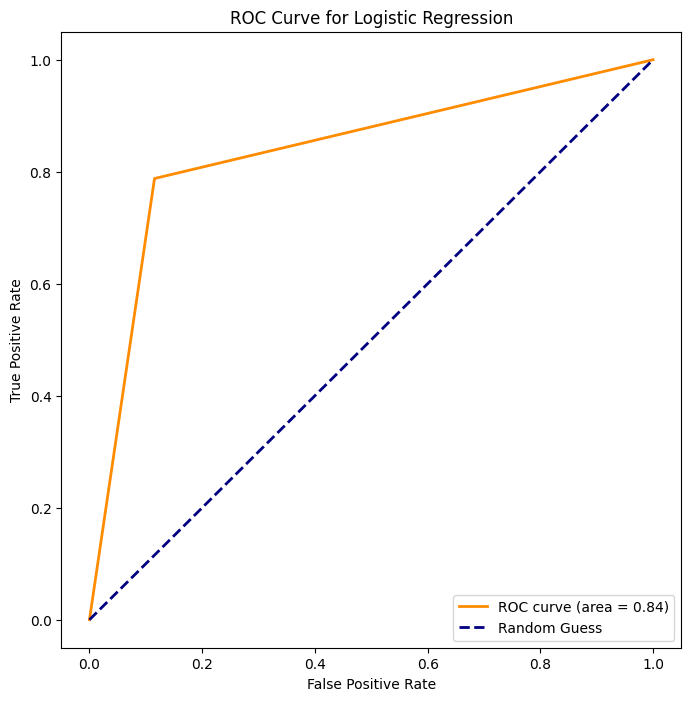

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_tensor, y_pred)

# Calculate the AUC
roc_auc = auc(fpr, tpr)
# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.show()